In [1]:
import numpy as np
import json
import re
from urllib.request import urlopen
from pyserini import search
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

np.random.seed(1)

[nltk_data] Downloading package wordnet to /home/robbie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/robbie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/robbie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read in text data for training

In [2]:
qfile = 'https://github.com/castorini/anserini-tools/blob/63ceeab1dd94c1221f29b931d868e8fab67cc25c/topics-and-qrels/qrels.robust04.txt?raw=true'
docids = set()
for line in urlopen(qfile):
  qid, round, docid, score = line.strip().split()
  new_docid = docid.decode('UTF-8')
  docids.add(new_docid)

docids = list(docids)
np.random.shuffle(docids)
len(docids), docids[0]

(174787, 'FBIS4-12433')

In [3]:
data = []
searcher = search.SimpleSearcher.from_prebuilt_index('robust04')
for docid in docids[:50]:
  try:
    text = searcher.doc(docid).raw()
    data.append(text)
  except:
    continue

cleaned_data = []
for text in data:
  new_text = text.replace('<P>', ' ')
  new_text = new_text.replace('</P>', ' ')
  new_text = new_text.replace('<DATE>', ' ')
  new_text = new_text.replace('</DATE>', ' ')
  new_text = new_text.replace('<HEADLINE>', ' ')
  new_text = new_text.replace('</HEADLINE>', ' ')
  new_text = new_text.replace('<TEXT>', ' ')
  new_text = new_text.replace('</TEXT>', ' ')
  new_text = new_text.replace('\n', ' ')
  new_text = new_text.replace("\'", '')
  new_text = new_text.replace('--', ' ')
  cleaned_data.append(new_text)
  
cleaned_data[0]

Attempting to initialize pre-built index robust04.
/home/robbie/.cache/pyserini/indexes/index-robust04-20191213.15f3d001489c97849a010b0a4734d018 already exists, skipping download.
Initializing robust04...


'  BFN  [Text] Security services said today that it had managed to kill four armed groups members and arrested four others in the capital, Boumerdes, Saida, between Friday and Sunday [8 and 10 April].   '

## Clean data

In [4]:
stemmer = nltk.stem.PorterStemmer()
stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    tokens = pattern.findall(text)
    stemmed_tokens = []
    for token in tokens:
      stemmed_token = stemmer.stem(token.replace("'", ''))
      if stemmed_token not in stop_words:
        stemmed_tokens.append(stemmed_token)
    return stemmed_tokens

tokens_by_doc = [tokenize(doc) for doc in cleaned_data[:25]]

In [5]:
tokens_by_doc[0]

['bfn',
 'text',
 'secur',
 'servic',
 'said',
 'today',
 'manag',
 'kill',
 'four',
 'arm',
 'group',
 'member',
 'arrest',
 'four',
 'capit',
 'boumerd',
 'saida',
 'friday',
 'sunday',
 'april']

In [6]:
# want to treat the tokens as one long list, rather than a list of tokens per document
# to do this, will insert a special character in between each document to stop the training there
# TLDR insert a stop token between each document to avoid using next/prev document as context
SPECIAL_STOP_TOKEN = '*!!!*'

def combine_tokens():
  ret = []
  for token_list in tokens_by_doc:
    ret.extend(token_list)
    ret.append(SPECIAL_STOP_TOKEN)

  return ret

tokens_with_stops = combine_tokens()

print(len(tokens_with_stops))
# should equal number of documents being used
len([token for token in tokens_with_stops if token == SPECIAL_STOP_TOKEN])

10671


25

## Create vocabulary maps

In [7]:
token_to_id = {}
id_to_token = {}

def make_vocabulary(tokens):
  for token in tokens:
    if token not in token_to_id:
      id_no = len(token_to_id) + 1
      token_to_id[token] = id_no
      id_to_token[id_no] = token

for doc in tokens_by_doc:
  make_vocabulary(doc)

print(len(token_to_id))

3238


## Create dataset

In [8]:
def create_one_hot(token_id):
  vector = np.zeros(len(token_to_id) + 1)
  vector[token_id] = 1
  return vector

def yield_range(*ranges):
  for iterable in ranges:
    yield from iterable

def create_dataset(window_size=2):
  X = []
  y = []
  
  # note that this includes stop tokens, which will need to be skipped
  token_count = len(tokens_with_stops)
  print(token_count)

  for i in range(token_count):
    if tokens_with_stops[i] == SPECIAL_STOP_TOKEN:
      continue

    indexes = yield_range(range(max(0, i - window_size), i), range(i, min(token_count, i + window_size + 1)))
    for j in indexes:
      if j == i:
        continue
      
      if tokens_with_stops[j] == SPECIAL_STOP_TOKEN:
        break

      X.append(create_one_hot(token_to_id[tokens_with_stops[i]]))
      y.append(create_one_hot(token_to_id[tokens_with_stops[j]]))

  return np.asarray(X), np.asarray(y)

X, y = create_dataset()

10671


In [9]:
X.shape, y.shape

((42338, 3239), (42338, 3239))

## Create and Initialize Network

In [10]:
def init_network(vocab_size: int, n_embeddings: int) -> dict:
  model = {
    'w1': np.random.randn(vocab_size + 1, n_embeddings),
    'w2': np.random.randn(n_embeddings, vocab_size + 1),
  }
  return model

### Train Model

In [11]:
def softmax(outputs):
  res = []
  for x in outputs:
    res.append(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())
  return res

def safe_log(array):
  for i in range(len(array)):
    for x in range(len(array[i])):
      if array[i][x] > 0:
        array[i][x] = np.log(array[i][x])
  return array

def cross_entropy_loss(z, y):
  return - np.sum(y * safe_log(z))

def forward_prop(model, X):
  cache = {}
  cache['a1'] = X @ model['w1']
  cache['a2'] = cache['a1'] @ model['w2']
  cache['z'] = softmax(cache['a2'])
  return cache

def back_prop(model, X, y, alpha):
  cache = forward_prop(model, X)
  da2 = cache['z'] - y
  dw2 = cache['a1'].T @ da2
  da1 = da2 @ model['w2'].T
  dw1 = X.T @ da1
  model['w1'] -= alpha * dw1
  model['w2'] -= alpha * dw2
  return cross_entropy_loss(cache['z'], y)

In [23]:
from tqdm import tqdm

# hyperparams
n_iter = 50
learning_rate = 0.005
embedding_size = 10

model = init_network(len(token_to_id), embedding_size)
model['w1'].shape, model['w2'].shape

losses = []

for i in tqdm(range(n_iter)):
  losses.append(back_prop(model, X, y, learning_rate))

100%|██████████| 50/50 [2:07:26<00:00, 152.93s/it]  


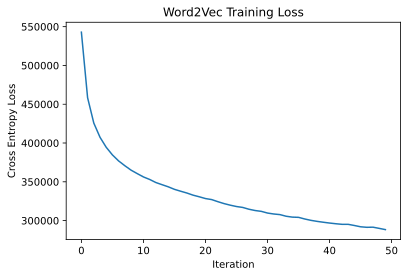

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(range(len(losses)), losses)
plt.title('Word2Vec Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.show()

### Evaluate Embeddings

In [25]:
def get_embedding(model, word, stem=True):
  try:
    if stem:
      token = stemmer.stem(word.replace("'", ''))
    else:
      token = word
    idx = token_to_id[token]
  except KeyError:
    print(f'{token} not in corpus')
  one_hot = create_one_hot(idx)
  return forward_prop(model, one_hot)['a1']

def magnitude(vector):
  return np.sqrt(np.sum(vector ** 2))

def cosim(vector1, vector2):
  dot = np.dot(vector1, vector2)
  mag_x = magnitude(vector1)
  mag_y = magnitude(vector2)
  return dot / (mag_x * mag_y)

def similar(model, word, num_common, reverseList=False):
  similarities = []
  word_embedding = get_embedding(model, word)
  for token in token_to_id.keys():
    if token == stemmer.stem(word):
      continue
    token_embedding = get_embedding(model, token, stem=False)
    similarities.append((cosim(token_embedding, word_embedding), token))
  similarities.sort(reverse=not reverseList)
  return similarities[:num_common]

In [32]:
# most similar vectors
similar(model, 'kill', 10)

[(0.9309699976736793, 'arson'),
 (0.909474896548192, 'chapter'),
 (0.8746196579820174, 'call'),
 (0.8663665625361024, 'add'),
 (0.8501816265636781, 'inhabit'),
 (0.8419881527185968, 'friday'),
 (0.8412854108165311, 'post'),
 (0.8266077503719477, 'comb'),
 (0.8233973861170264, 'travelworld'),
 (0.822460467816277, 'purchas')]

In [33]:
# least similar vectors
similar(model, 'kill', 10, reverseList=True)

[(-0.750201470305689, 'stood'),
 (-0.7487894374435773, 'hanson'),
 (-0.7408225338957326, 'norcro'),
 (-0.7140584122733876, 'nippon'),
 (-0.7122910404436331, 'implac'),
 (-0.7049203011912455, 'mainstream'),
 (-0.6945615586450545, 'databas'),
 (-0.6914398326626839, 'everyth'),
 (-0.6852336067172714, 'squar'),
 (-0.6801752241970188, 'bailli')]

In [29]:
import json

def save_model(model, output_name='embeddings.json'):
  embedding_dict = {}
  for token in token_to_id.keys():
    embedding_dict[token] = list(get_embedding(model, token, stem=False))
  
  with open(output_name, 'w') as outfile:
    json.dump(embedding_dict, outfile, indent=4)

save_model(model)

In [31]:
token_to_id

{'bfn': 1,
 'text': 2,
 'secur': 3,
 'servic': 4,
 'said': 5,
 'today': 6,
 'manag': 7,
 'kill': 8,
 'four': 9,
 'arm': 10,
 'group': 11,
 'member': 12,
 'arrest': 13,
 'capit': 14,
 'boumerd': 15,
 'saida': 16,
 'friday': 17,
 'sunday': 18,
 'april': 19,
 'ft': 20,
 'nov': 21,
 'indian': 22,
 'broker': 23,
 'strike': 24,
 'fee': 25,
 'stockbrok': 26,
 'yesterday': 27,
 'stage': 28,
 'protest': 29,
 'introduct': 30,
 'hefti': 31,
 'registr': 32,
 'bring': 33,
 'trade': 34,
 'countri': 35,
 'exchang': 36,
 'halt': 37,
 'noth': 38,
 'restor': 39,
 'investor': 40,
 'confid': 41,
 'market': 42,
 'ha': 43,
 'suffer': 44,
 'thi': 45,
 'year': 46,
 'rs35bn': 47,
 'pound': 48,
 '812m': 49,
 'bombay': 50,
 'scandal': 51,
 'furthermor': 52,
 'aggrav': 53,
 'danger': 54,
 'default': 55,
 'among': 56,
 'sinc': 57,
 'rapid': 58,
 'fall': 59,
 'share': 60,
 'price': 61,
 'recent': 62,
 'week': 63,
 'strain': 64,
 'financ': 65,
 'stock': 66,
 'bse': 67,
 'index': 68,
 'fallen': 69,
 'fifth': 70,
 'pa